In [1]:
# imports
import os
import sys
import time
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from tf_cnnvis import *

np.random.seed(10)

%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# helper method to define model
def deepnn(x):
    x_image = tf.reshape(x, [-1, 56, 56, 1])
#     x_image = tf.image.resize_image_with_crop_or_pad(x_image, target_height=32, target_width=32)

    W_conv1 = weight_variable([5, 5, 1, 6])
    b_conv1 = bias_variable([6])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([5, 5, 6, 16])
    b_conv2 = bias_variable([16])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    h_pool2 = max_pool_2x2(h_conv2)

    W_conv3 = weight_variable([5, 5, 16, 10])
    b_conv3 = bias_variable([10])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    
    h_pool3 = max_pool_2x2(h_conv3)
    
    gap_1 = tf.nn.avg_pool(h_pool3, ksize=[1, 7, 7, 1], strides=[1, 7, 7, 1], padding='SAME')
    
    dense = tf.reshape(gap_1, [-1, 10])
    
    return x_image, dense, h_conv1, h_pool1, h_conv2, h_pool2, h_conv3, h_pool3, gap_1


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [7]:
input_img = tf.placeholder(tf.float32, shape=[None, 784])

output_1 = tf.pad(tf.reshape(input_img, (28, 28, 1)), [[0, 28], [0, 28], [0,0]])
output_3 = tf.pad(tf.reshape(input_img, (28, 28, 1)), [[28, 0], [0, 28], [0,0]])
output_2 = tf.pad(tf.reshape(input_img, (28, 28, 1)), [[0, 28], [28, 0], [0,0]])
output_4 = tf.pad(tf.reshape(input_img, (28, 28, 1)), [[28, 0], [28, 0], [0,0]])

op_dict = [output_1, output_2, output_3, output_4]
sess_2 = tf.Session()

def generate_bigger_images(batch, no_samples=50):
    new_batch = []
    for i in range(no_samples):
        t = np.random.randint(0, high=4)
        op = sess_2.run(op_dict[t], feed_dict={input_img: batch[i].reshape(-1, 784)})
        new_batch.append(np.array(op.reshape(3136)))
        
    return np.array(new_batch)

In [4]:
#load graph and data and run training

tf.reset_default_graph()

# reading data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# defining TF model
x = tf.placeholder(tf.float32, [None, 56*56])
y_ = tf.placeholder(tf.float32, [None, 10])
x_image, y_conv, h_conv1, h_pool1, h_conv2, h_pool2, h_conv3, h_pool3, gap_1 = deepnn(x)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_conv, labels = y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# trainning CNN
sess= tf.Session()

sess.run(tf.global_variables_initializer())
with sess.as_default():
    for i in range(10000):
        batch = mnist.train.next_batch(50)
        new_batch = generate_bigger_images(batch, 50)
        if i%10 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:new_batch, y_: batch[1]})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: new_batch, y_: batch[1]})
        
    x_feed = mnist.test.images.reshape(-1, 784)[:100]
    y_feed = mnist.test.labels.reshape(-1, 10)[:100]
    new_x_feed = generate_bigger_images(x_feed, 50)
    print("test accuracy %g"%accuracy.eval(feed_dict={x: new_x_feed, y_: y_feed, 
                                                      }))

#     test_x = mnist.test.images.reshape(-1, 784)[0]
#     test_y = mnist.test.images.reshape(-1, 10)[0]
#     feed_dict = {x: test_x, y:test_y}

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

step 0, training accuracy 0.18
step 10, training accuracy 0.08
step 20, training accuracy 0.06
step 30, training accuracy 0.06
step 40, training accuracy 0.08
step 50, training accuracy 0.08
step 60, training accuracy 0.1
step 70, training accuracy 0.1
step 80, training accuracy 0.02
step 90, training accuracy 0.18
step 100, training accuracy 0.12
step 110, training accuracy 0.16
step 120, training accuracy 0.06
step 130, training accuracy 0.12
step 140, training accuracy 0.08
step 150, training accuracy 0.12
step 160, training accuracy 0.1
step 170, training accuracy 0.08
step 180, training accuracy 0.16
step

step 2290, training accuracy 0.42
step 2300, training accuracy 0.4
step 2310, training accuracy 0.54
step 2320, training accuracy 0.36
step 2330, training accuracy 0.44
step 2340, training accuracy 0.48
step 2350, training accuracy 0.48
step 2360, training accuracy 0.54
step 2370, training accuracy 0.48
step 2380, training accuracy 0.46
step 2390, training accuracy 0.48
step 2400, training accuracy 0.46
step 2410, training accuracy 0.58
step 2420, training accuracy 0.54
step 2430, training accuracy 0.4
step 2440, training accuracy 0.4
step 2450, training accuracy 0.52
step 2460, training accuracy 0.46
step 2470, training accuracy 0.46
step 2480, training accuracy 0.48
step 2490, training accuracy 0.54
step 2500, training accuracy 0.5
step 2510, training accuracy 0.34
step 2520, training accuracy 0.36
step 2530, training accuracy 0.4
step 2540, training accuracy 0.42
step 2550, training accuracy 0.58
step 2560, training accuracy 0.5
step 2570, training accuracy 0.58
step 2580, training 

step 4720, training accuracy 0.7
step 4730, training accuracy 0.6
step 4740, training accuracy 0.72
step 4750, training accuracy 0.68
step 4760, training accuracy 0.76
step 4770, training accuracy 0.68
step 4780, training accuracy 0.74
step 4790, training accuracy 0.64
step 4800, training accuracy 0.66
step 4810, training accuracy 0.64
step 4820, training accuracy 0.78
step 4830, training accuracy 0.72
step 4840, training accuracy 0.72
step 4850, training accuracy 0.7
step 4860, training accuracy 0.8
step 4870, training accuracy 0.8
step 4880, training accuracy 0.72
step 4890, training accuracy 0.72
step 4900, training accuracy 0.7
step 4910, training accuracy 0.72
step 4920, training accuracy 0.7
step 4930, training accuracy 0.82
step 4940, training accuracy 0.8
step 4950, training accuracy 0.8
step 4960, training accuracy 0.64
step 4970, training accuracy 0.76
step 4980, training accuracy 0.62
step 4990, training accuracy 0.64
step 5000, training accuracy 0.76
step 5010, training acc

step 7150, training accuracy 0.92
step 7160, training accuracy 0.82
step 7170, training accuracy 0.76
step 7180, training accuracy 0.72
step 7190, training accuracy 0.74
step 7200, training accuracy 0.8
step 7210, training accuracy 0.8
step 7220, training accuracy 0.78
step 7230, training accuracy 0.76
step 7240, training accuracy 0.78
step 7250, training accuracy 0.82
step 7260, training accuracy 0.8
step 7270, training accuracy 0.74
step 7280, training accuracy 0.82
step 7290, training accuracy 0.76
step 7300, training accuracy 0.88
step 7310, training accuracy 0.9
step 7320, training accuracy 0.88
step 7330, training accuracy 0.84
step 7340, training accuracy 0.84
step 7350, training accuracy 0.82
step 7360, training accuracy 0.8
step 7370, training accuracy 0.88
step 7380, training accuracy 0.78
step 7390, training accuracy 0.7
step 7400, training accuracy 0.76
step 7410, training accuracy 0.86
step 7420, training accuracy 0.88
step 7430, training accuracy 0.66
step 7440, training 

step 9580, training accuracy 0.82
step 9590, training accuracy 0.88
step 9600, training accuracy 0.82
step 9610, training accuracy 0.9
step 9620, training accuracy 0.76
step 9630, training accuracy 0.88
step 9640, training accuracy 0.88
step 9650, training accuracy 0.82
step 9660, training accuracy 0.86
step 9670, training accuracy 0.88
step 9680, training accuracy 0.74
step 9690, training accuracy 0.9
step 9700, training accuracy 0.86
step 9710, training accuracy 0.92
step 9720, training accuracy 0.96
step 9730, training accuracy 0.82
step 9740, training accuracy 0.84
step 9750, training accuracy 0.88
step 9760, training accuracy 0.9
step 9770, training accuracy 0.82
step 9780, training accuracy 0.82
step 9790, training accuracy 0.8
step 9800, training accuracy 0.82
step 9810, training accuracy 0.84
step 9820, training accuracy 0.86
step 9830, training accuracy 0.88
step 9840, training accuracy 0.84
step 9850, training accuracy 0.74
step 9860, training accuracy 0.86
step 9870, trainin

ValueError: cannot reshape array of size 1 into shape (784)

In [8]:
saver = tf.train.Saver()

saver.save(sess, './model/deconv_gap_big_chkpt')


# deconv visualization
test_x = mnist.test.images.reshape(-1, 784)[0:1]
test_y = mnist.test.labels.reshape(-1, 10)[0:1]
test_x_feed = generate_bigger_images(test_x, 1)

# feed_dict = {x: test_x, y_:test_y}

# layers = ["r", "p", "c"]
# total_time = 0

# start = time.time()
#     # api call
# is_success = deconv_visualization(sess_graph_path = sess, value_feed_dict = feed_dict, 
#                                   input_tensor=x_image, layers=layers, 
#                                   path_logdir=os.path.join("Log","MNISTExample"), 
#                                   path_outdir=os.path.join("Output","MNISTExample"))
# start = time.time() - start
# print("Total Time = %f" % (start))

In [10]:
# start = time.time()
#     # api call
# is_success = activation_visualization(sess_graph_path = sess, value_feed_dict = feed_dict, 
#                                   input_tensor=x_image, layers=layers, 
#                                   path_logdir=os.path.join("Log","MNISTExample"), 
#                                   path_outdir=os.path.join("Output","MNISTExample"))
# start = time.time() - start
# print("Total Time = %f" % (start))

INFO:tensorflow:Restoring parameters from model/tmp-model
Reconstruction Completed for Relu layer. Time taken = 0.673796 s
Reconstruction Completed for Relu_1 layer. Time taken = 0.049525 s
Reconstruction Completed for Relu_2 layer. Time taken = 0.081727 s
Reconstruction Completed for Relu_3 layer. Time taken = 0.036901 s
Reconstruction Completed for MaxPool layer. Time taken = 0.028609 s
Reconstruction Completed for MaxPool_1 layer. Time taken = 0.042631 s
Reconstruction Completed for Conv2D layer. Time taken = 0.047269 s
Reconstruction Completed for Conv2D_1 layer. Time taken = 0.032229 s
Total Time = 4.159668


In [9]:
import matplotlib.pyplot as plt

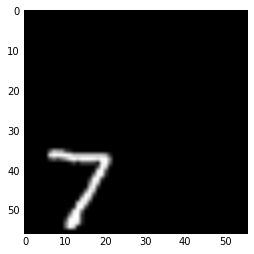

In [11]:
plt.imshow(test_x_feed.reshape(56, 56), cmap='gray')

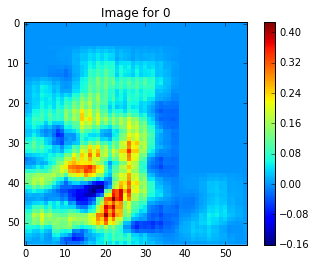

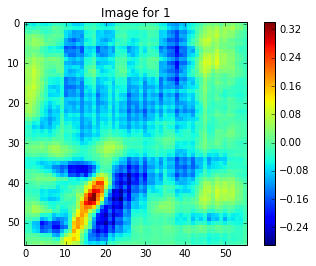

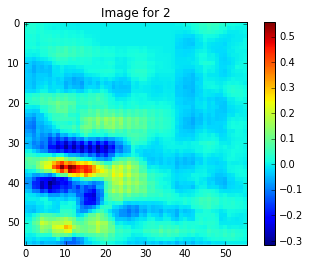

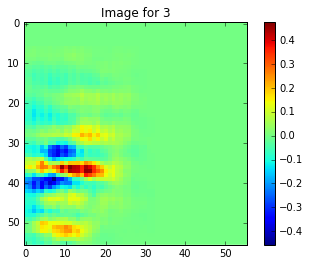

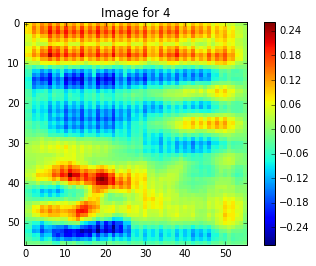

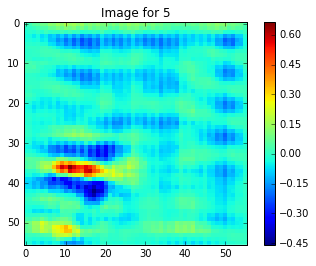

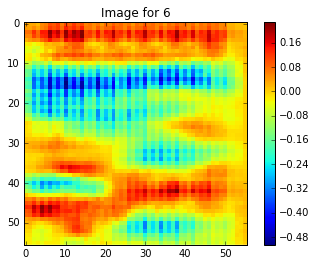

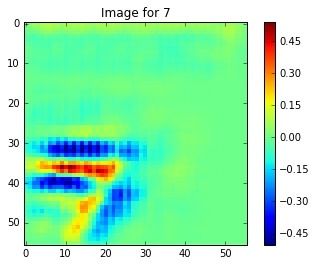

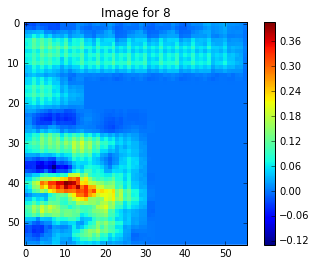

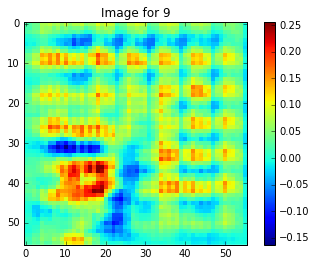

In [14]:
# y_res = sess.run(h_conv1, {x:test_x.reshape(-1, 784)})

for i in range(10):
    deriv = tf.gradients(y_conv[0][i], x)
    # y_res[0][1

    dydx = sess.run(deriv, {x:test_x_feed.reshape(-1, 3136)})

    dydx = np.array(dydx)
    
    fig, ax = plt.subplots()

    im = ax.imshow(dydx.reshape((56, 56)), cmap='jet', interpolation='none')

#     print('Image for {}'.format(i))
    plt.title('Image for {}'.format(i))
    fig.colorbar(im, ax=ax)

#     plt.savefig('./Output/LeNet/Output_Layer/filter_{}.jpg'.format(i))